# **Final Project: Neural Networks and Deep Learning**

# Music Genre Classification with CNN

In [ ]:
pip install scikeras

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

In [ ]:
pip install --upgrade librosa

In [ ]:
pip install pysoundfile

## Step 1: Dataset Selection

In [ ]:
# Load GTZAN dataset
DATASET_PATH = "/content/drive/MyDrive/GTZAN Dataset/genres_original"  # Update with your dataset path

In [ ]:
def load_audio_files_with_augmentation(dataset_path):
    genres = []
    mfcc_features = []
    labels = []

    for genre in os.listdir(dataset_path):
        if os.path.isdir(os.path.join(dataset_path, genre)):
            genres.append(genre)
            for file in os.listdir(os.path.join(dataset_path, genre)):
                file_path = os.path.join(dataset_path, genre, file)
                try:
                    signal, sr = librosa.load(file_path, duration=30)
                    # Original MFCC
                    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=60)
                    mfcc = np.mean(mfcc.T, axis=0)
                    mfcc_features.append(mfcc)
                    labels.append(genre)
                except Exception as e:
                    print(f"Skipping file {file_path}: {e}")

    return np.array(mfcc_features), np.array(labels)

In [ ]:
# Load the dataset
X, y = load_audio_files_with_augmentation(DATASET_PATH)

Skipping file /content/drive/MyDrive/GTZAN Dataset/genres_original/jazz/.ipynb_checkpoints: module 'soundfile' has no attribute 'SoundFileRuntimeError'


## Step 2: Data Cleaning

### In this case, since all audio files are processed, there are no missing values.

## Step 3: Data Exploration

In [ ]:
# Convert labels to categorical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

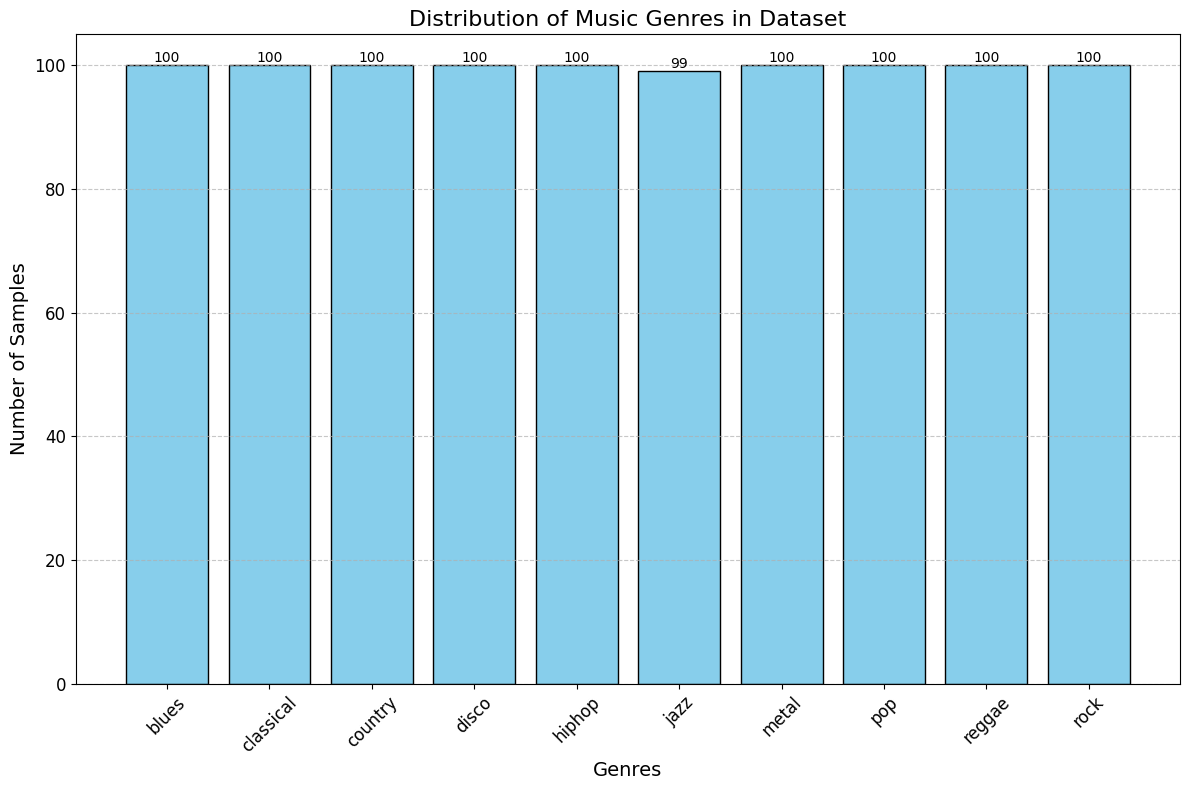

In [ ]:
# Visual exploration - Plot distribution of music genres
plt.figure(figsize=(12, 8))
unique, counts = np.unique(y, return_counts=True)
bars = plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Distribution of Music Genres in Dataset', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=10, color='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

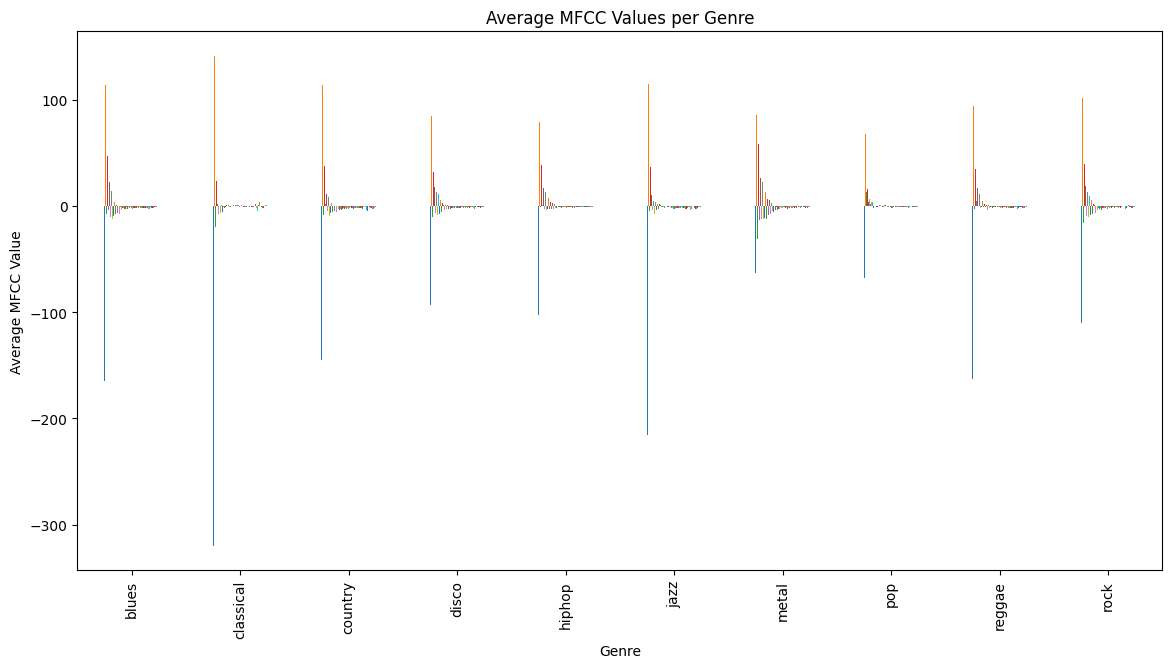

In [ ]:
feature_means = pd.DataFrame(X, columns=[f'MFCC_{i}' for i in range(60)])
feature_means['Genre'] = y
feature_means.groupby('Genre').mean().plot(kind='bar', figsize=(14, 7), legend=False)
plt.title('Average MFCC Values per Genre')
plt.xlabel('Genre')
plt.ylabel('Average MFCC Value')
plt.show()

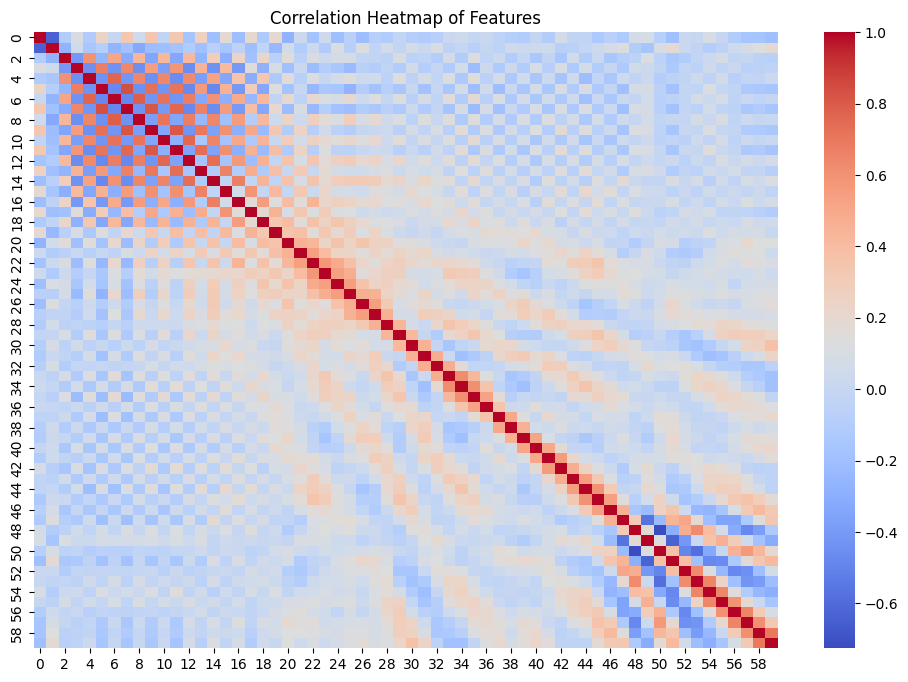

In [ ]:
import seaborn as sns
genre_correlation = pd.DataFrame(X).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(genre_correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

**Key Insights:**

- High Correlation Among Some MFCC Features:

Certain MFCC coefficients (e.g., diagonal clusters) show a strong positive correlation with one another (darker red blocks), indicating redundancy or shared information. This suggests some features might be linearly dependent and could potentially be reduced using techniques like PCA to improve model efficiency.

- Negative Correlation:

Some coefficients have strong negative correlations with others (blue blocks), suggesting contrasting patterns in their representation. This could mean these features provide complementary information, which is useful for classification.

- Uncorrelated Features:

Lighter colors (near 0) represent weak or no correlation between features. These features might add unique, non-redundant information to the model, which is beneficial for diversity in learning.

## Feature Engineering

In [ ]:
# MFCC is used as the main feature for this task
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

In [ ]:
# Reshape data for CNN (CNN expects 4D input, hence reshape to (samples, height, width, channels))
# Verify and reshape data dynamically
n_features = X_train.shape[1]  # Dynamically determine the number of features
X_train = X_train.reshape(X_train.shape[0], n_features, 1, 1)
X_test = X_test.reshape(X_test.shape[0], n_features, 1, 1)

## Step 5: Model Selection

In [ ]:
# CNN for classification

def create_simple_model(optimizer='adam', dropout_rate=0.3):
    model = Sequential()
    model.add(tf.keras.Input(shape=(60, 1, 1)))
    model.add(Conv2D(16, (3, 1), activation='relu'))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_simple_model, verbose=0, dropout_rate=0.3, optimizer='adam', batch_size=64, epochs=50)

## Step 6: Hyperparameter Tuning

In [ ]:
# Define hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 60, 80, 100]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, cv=3, verbose=1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=64, build_fn=<function create_simple_model at 0x7b496ba5f490>, dropout_rate=0.3, epochs=50, optimizer='adam', verbose=0),
                   n_iter=5,
                   param_distributions={'batch_size': [32, 64],
                                        'dropout_rate': [0.2, 0.3],
                                        'epochs': [50, 60, 80, 100],
                                        'optimizer': ['adam', 'rmsprop']},
                   verbose=1)

In [ ]:
# Best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'optimizer': 'adam', 'epochs': 60, 'dropout_rate': 0.2, 'batch_size': 64}


In [ ]:
# Train model with best hyperparameters
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

final_model = create_simple_model(optimizer=best_params['optimizer'], dropout_rate=best_params['dropout_rate'])
history = final_model.fit(
    X_train,
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1704 - loss: 2.2332 - val_accuracy: 0.4250 - val_loss: 1.8256 - learning_rate: 0.0010
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3950 - loss: 1.8270 - val_accuracy: 0.5000 - val_loss: 1.5331 - learning_rate: 0.0010
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4920 - loss: 1.5442 - val_accuracy: 0.5900 - val_loss: 1.3260 - learning_rate: 0.0010
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5424 - loss: 1.3816 - val_accuracy: 0.6100 - val_loss: 1.2404 - learning_rate: 0.0010
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5992 - loss: 1.1867 - val_accuracy: 0.6350 - val_loss: 1.1397 - learning_rate: 0.0010
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6457 - loss: 1.0763 - val_accuracy: 0.6550 - val_loss: 1.1199 - learning_rate: 0.0010
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6601 - loss: 1.0097 - val_accuracy:

## Step 7: Pickle Files

In [ ]:
# Save model and scaler
with open('music_genre_simple_cnn_model.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [ ]:
from tensorflow.keras.models import save_model
save_model(final_model, 'music_genre_model_new.keras')

## Step 8: Flask or Streamlit Web Application

In [ ]:
# Create a Streamlit application
try:
    import streamlit as st
    st.title("Music Genre Classification")
    file_input = st.file_uploader("Upload an audio file")
    if file_input:
        # Load audio file and extract MFCC features
        signal, sr = librosa.load(file_input, duration=30)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=60)
        mfcc = np.mean(mfcc.T, axis=0)
        mfcc_scaled = scaler.transform([mfcc])
        mfcc_reshaped = mfcc_scaled.reshape(1, 60, 1, 1)

        # Predict genre
        prediction = final_model.predict(mfcc_reshaped)
        predicted_genre = label_encoder.inverse_transform([np.argmax(prediction)])
        st.write(f"The predicted genre is: {predicted_genre[0]}")
except ModuleNotFoundError:
    print("Streamlit module is not installed. Please install it using 'pip install streamlit'.")

## Step 9: GitHub Repository

In [ ]:
# Upload your project to a GitHub repository with a README file with all the necessary instructions.